In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Training kNN
For kNN training first 225 digits of pi were taken. The Font on Libre Link Up is Source Sans 3

Taken from https://stackoverflow.com/questions/9413216/simple-digit-recognition-ocr-in-opencv-python

training complete


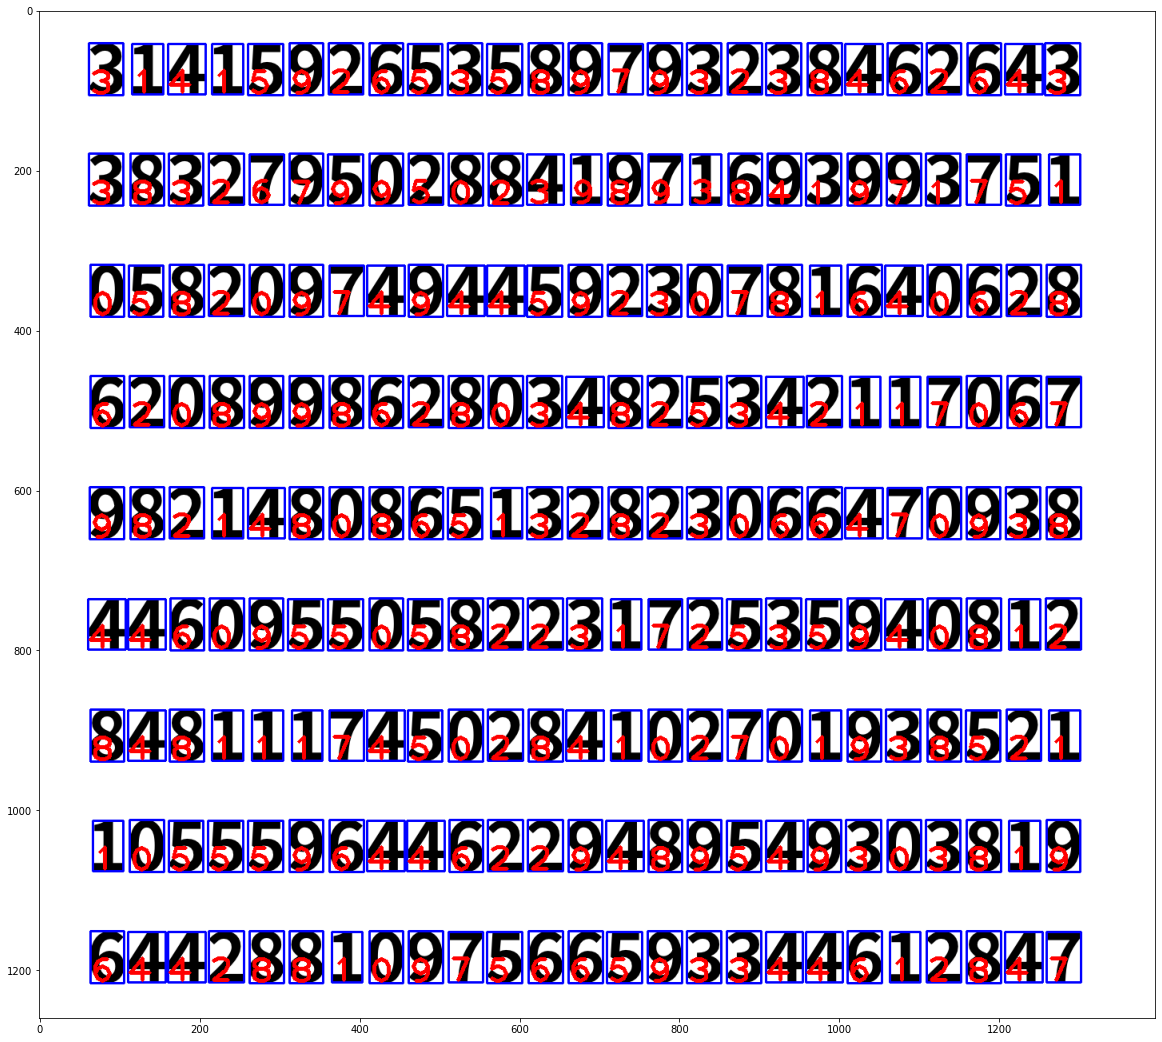

In [28]:
im = cv2.imread('train.png')
im3 = im.copy()

gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(5,5),0)
thresh = cv2.adaptiveThreshold(blur,255,1,1,11,2)

#################      Now finding Contours         ###################

hierarchy,contours,_ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
def get_contour_precedence(contour, cols):
    tolerance_factor = 10
    origin = cv2.boundingRect(contour)
    return ((origin[1] // tolerance_factor) * tolerance_factor) * cols + origin[0]


contours.sort(key=lambda x:get_contour_precedence(x, img.shape[1]))

samples =  np.empty((0,100))
chars = '314159265358979323846264338327950288419716939937510582097494459230781640628620899862803482534211706798214808651328230664709384460955058223172535940812848111745028410270193852110555964462294895493038196442881097566593344612847'
chars = list(chars)
responses = []
count = 0
for cnt in contours:
    [x,y,w,h] = cv2.boundingRect(cnt)
    
    if  h>28 and w>28:
        im = cv2.rectangle(im,(x,y),(x+w,y+h),(0,0,255),2)
        im = cv2.putText(im,chars[count],(x,y+h),1,3,(255,0,0),3)
        roi = thresh[y:y+h,x:x+w]
        roismall = cv2.resize(roi,(10,10))
        responses.append(int(chars[count]))
        sample = roismall.reshape((1,100))
        samples = np.append(samples,sample,0)
        count+=1

responses = np.array(responses,np.float32)
responses = responses.reshape((responses.size,1))
print("training complete")

plt.figure(figsize=(20,20))
plt.imshow(im)

np.savetxt('generalsamples.data',samples)
np.savetxt('generalresponses.data',responses)


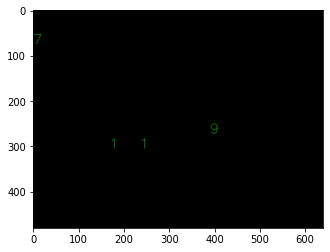

In [29]:
#######   training part    ############### 
samples = np.loadtxt('generalsamples.data',np.float32)
responses = np.loadtxt('generalresponses.data',np.float32)
responses = responses.reshape((responses.size,1))

model = cv2.ml.KNearest_create()
model.train(samples,cv2.ml.ROW_SAMPLE,responses)

############################# testing part  #########################
img = cv2.imread("YOUR_IMAGE.png")
im = img.copy()
out = np.zeros(im.shape,np.uint8)
gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
# thresh = cv2.adaptiveThreshold(gray,255,1,1,11,2)
thresh2 = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)
thresh = cv2.morphologyEx(thresh2[1], cv2.MORPH_OPEN, (5,5))

hierarchy,contours,_ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    if cv2.contourArea(cnt)>50:
        [x,y,w,h] = cv2.boundingRect(cnt)
        if  h>40 and w > 40:
            cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),2)
            roi = thresh[y:y+h,x:x+w]
            roismall = cv2.resize(roi,(10,10))
            roismall = roismall.reshape((1,100))
            roismall = np.float32(roismall)
            retval, results, neigh_resp, dists = model.findNearest(roismall, k = 1)
            string = str(int((results[0][0])))
            cv2.putText(out,string,(x,y+h),0,1,(0,255,0))

plt.imshow(out)